## CSE 4705 Project: Supervised Analysis

Tom McCarthy & Filip Graham

### Pre-processing: Combining unstructured data with structured data

As a continuation from the previous deliverable, we take the JSONs parsed from municipal report pdfs and combine them with our real estate summary csv dataset. A sample json file and the combined dataset csv is included with this submission.

In [ ]:
import csv
import json
import os
from pprint import pprint

years_overlap = [2019, 2021, 2023]

# Relative file paths
base_dir = os.path.dirname(__file__)  # Get the directory of the current script
csv_file_path = os.path.join(base_dir, 'cse4705_summary_data.csv')
json_folder_path = os.path.join(base_dir, 'outputs_in_json')
output_csv_path = os.path.join(base_dir, 'cse4705_summary_data_csv_combined_with_json.csv')

# Read the CSV file
with open(csv_file_path, mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    csv_data = list(csv_reader)
    csv_fieldnames = csv_reader.fieldnames


# Collect JSON data
json_data = {}
valid_years = {2019, 2021, 2023}  # Define the set of valid years
for json_file_name in os.listdir(json_folder_path):
    if json_file_name.endswith('.json'):
        town_year = json_file_name.replace('.json', '')
        # Extract the year from the file name
        _, year = town_year.rsplit('-', 1)
        if int(year) in valid_years:  # Check if the year is in the valid set
            with open(os.path.join(json_folder_path, json_file_name), mode='r') as json_file:
                json_data[town_year] = json.load(json_file)
# print('json_data START')
# pprint(json_data)

# Add JSON data as new columns to the CSV
for row in csv_data:
    year = row['year']
    town = row['town']
    town_year_key = f"{town}-{year}"
    if town_year_key in json_data:
        for key, value in json_data[town_year_key].items():
            row[key] = value # 

# Write the updated data to a new CSV file
new_fieldnames = csv_fieldnames + list({
    key for town_year_key in json_data for key in json_data[town_year_key]
})
"""
town_year_key = [Woodstock-2019, 'Woodstock-2021', Woodstock-2023]

key = [
    'Median Age: Town': 46,
    'Poverty Rate: Town': 6.0,
    'Race/Ethnicity: Asian: Town': 40,
    'Race/Ethnicity: Black: Town': 0,
    'Race/Ethnicity: Hispanic: Town': 160,
    'Race/Ethnicity: Other: Town': 158,
    'Race/Ethnicity: White: Town': 7469},
]
"""
# print('new_filednames are BELOW')
# pprint(new_fieldnames)

with open(output_csv_path, mode='w', newline='') as output_csv_file:
    csv_writer = csv.DictWriter(output_csv_file, fieldnames=new_fieldnames)
    csv_writer.writeheader()
    csv_writer.writerows(csv_data)

print(f"Combined data has been written to {output_csv_path}")

## Random Forest Classification: Predicting county using other features

We hypothesize that we can differentiate and predict localities using our municipal dataset. It would be useful to develop a list of the most "important" features which identify localities to refine our focus from the many features. Given that there are 169 municipalities in Connecticut and we only have datapoints for a limited number of years, it will be difficult to develop a model which can accurately predict municipality. Therefore, we try to predict county instead.

We use Random Forest because it is a robust classifier that generally works well. Our dataset is not sparse, nor exteremely large.

Imports

In [1]:
import pandas as pd
import statsmodels.formula.api as sm
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

Load dataset

In [5]:
raw_data = pd.read_csv("cse4705_summary_data_old.csv")
print(raw_data.shape)

(812, 67)


Map towns to counties

In [6]:
counties = {"Andover":"Tolland","Ansonia":"New Haven","Ashford":"Windham","Avon":"Hartford","Barkhamsted":"Litchfield","Beacon Falls":"New Haven","Berlin":"Hartford","Bethany":"New Haven","Bethel":"Fairfield","Bethlehem":"Litchfield","Bloomfield":"Hartford","Bolton":"Tolland","Bozrah":"New London","Branford":"New Haven","Bridgeport":"Fairfield","Bridgewater":"Litchfield","Bristol":"Hartford","Brookfield":"Fairfield","Brooklyn":"Windham","Burlington":"Hartford","Canaan":"Litchfield","Canterbury":"Windham","Canton":"Hartford","Chaplin":"Windham","Cheshire":"New Haven","Chester":"Middlesex","Clinton":"Middlesex","Colchester":"New London","Colebrook":"Litchfield","Columbia":"Tolland","Cornwall":"Litchfield","Coventry":"Tolland","Cromwell":"Middlesex","Danbury":"Fairfield","Darien":"Fairfield","Deep River":"Middlesex","Derby":"New Haven","Durham":"Middlesex","East Granby":"Hartford","East Haddam":"Middlesex","East Hampton":"Middlesex","East Hartford":"Hartford","East Haven":"New Haven","East Lyme":"New London","East Windsor":"Hartford","Eastford":"Windham","Easton":"Fairfield","Ellington":"Tolland","Enfield":"Hartford","Essex":"Middlesex","Fairfield":"Fairfield","Farmington":"Hartford","Franklin":"New London","Glastonbury":"Hartford","Goshen":"Litchfield","Granby":"Hartford","Greenwich":"Fairfield","Griswold":"New London","Groton":"New London","Guilford":"New Haven","Haddam":"Middlesex","Hamden":"New Haven","Hampton":"Windham","Hartford":"Hartford","Hartland":"Hartford","Harwinton":"Litchfield","Hebron":"Tolland","Kent":"Litchfield","Killingly":"Windham","Killingworth":"Middlesex","Lebanon":"New London","Ledyard":"New London","Lisbon":"New London","Litchfield":"Litchfield","Lyme":"New London","Madison":"New Haven","Manchester":"Hartford","Mansfield":"Tolland","Marlborough":"Hartford","Meriden":"New Haven","Middlebury":"New Haven","Middlefield":"Middlesex","Middletown":"Middlesex","Milford":"New Haven","Monroe":"Fairfield","Montville":"New London","Morris":"Litchfield","Naugatuck":"New Haven","New Britain":"Hartford","New Canaan":"Fairfield","New Fairfield":"Fairfield","New Hartford":"Litchfield","New Haven":"New Haven","New London":"New London","New Milford":"Litchfield","Newington":"Hartford","Newtown":"Fairfield","Norfolk":"Litchfield","North Branford":"New Haven","North Canaan":"Litchfield","North Haven":"New Haven","North Stonington":"New London","Norwalk":"Fairfield","Norwich":"New London","Old Lyme":"New London","Old Saybrook":"Middlesex","Orange":"New Haven","Oxford":"New Haven","Plainfield":"Windham","Plainville":"Hartford","Plymouth":"Litchfield","Pomfret":"Windham","Portland":"Middlesex","Preston":"New London","Prospect":"New Haven","Putnam":"Windham","Redding":"Fairfield","Ridgefield":"Fairfield","Rocky Hill":"Hartford","Roxbury":"Litchfield","Salem":"New London","Salisbury":"Litchfield","Scotland":"Windham","Seymour":"New Haven","Sharon":"Litchfield","Shelton":"Fairfield","Sherman":"Fairfield","Simsbury":"Hartford","Somers":"Tolland","South Windsor":"Hartford","Southbury":"New Haven","Southington":"Hartford","Sprague":"New London","Stafford":"Tolland","Stamford":"Fairfield","Sterling":"Windham","Stonington":"New London","Stratford":"Fairfield","Suffield":"Hartford","Thomaston":"Litchfield","Thompson":"Windham","Tolland":"Tolland","Torrington":"Litchfield","Trumbull":"Fairfield","Union":"Tolland","Vernon":"Tolland","Voluntown":"New London","Wallingford":"New Haven","Warren":"Litchfield","Washington":"Litchfield","Waterbury":"New Haven","Waterford":"New London","Watertown":"Litchfield","West Hartford":"Hartford","West Haven":"New Haven","Westbrook":"Middlesex","Weston":"Fairfield","Westport":"Fairfield","Wethersfield":"Hartford","Willington":"Tolland","Wilton":"Fairfield","Winchester":"Litchfield","Windham":"Windham","Windsor":"Hartford","Windsor Locks":"Hartford","Wolcott":"New Haven","Woodbridge":"New Haven","Woodbury":"Litchfield","Woodstock":"Windham"}
raw_data['county'] = raw_data['town'].map(counties)

We search for the most important features by adding each one to the model and then measuring the accuracy. We use accuracy because this dataset is not unbalanced, and this classficiation is not binary. There are some columns which measure very similar things, i.e. avg_sale_price and median_sale_price. It would be redundant to include both. Therefore, we group similar columns together so that we choose the best column from each group. In each iteration, we split into training and test dataset, and then record the accuracy score.

In [7]:
columns=[["count"],
["avg_sale_price","sale_price_q1","median_sale_price","sale_price_q3"],
["avg_sales_ratio","sales_ratio_q1","median_sales_ratio","sales_ratio_q3"],
["avg_assessed_value","assessed_value_q1","median_assessed_value","assessed_value_q3","Median_value_of_owner_occupied_homes_ACS"],
["Equalized_net_grand_list","FYE_total_net_grand_list","Total_net_grand_list"],
["Grand_list_net_real_property","Grand_list_total_real_property","Total_exempt_and_taxable_property_assessment"],
["Grand_list_net_personal_property","Grand_list_personal_property"],
["Grand_list_total_net_motor_vehicle","Grand_list_motor_vehicle"],
["Grand_list_apartment"],
["Grand_list_commercial"],
["Grand_list_income_and_expense"],
["Grand_list_industrial"],
["Grand_list_land_use"],
["Grand_list_public_utility"],
["Grand_list_residential"],
["Grand_list_ten_mill_land"],
["Grand_list_vacant_land"],
["Mill_rate_motor_vehicle"],
["Mill_rate_real_and_personal_property"],
["Net_current_education_expenditures_CSDE","Net_current_education_expenditures_per_pupil_CSDE"],
["Per_capita_income_ACS"],
["School_enrollment_average_daily_membershipCSDE"],
["Area_in_sq_miles_2020_census"],
["Tax_exempt_property_as_a_percent_of_total"],
["Tax_exempt_property_assessment"],
["Estimated_population_DPH"]]
curr_columns, accuracies = [], []

for group in columns:
    best_accuracy = 0
    best_column = ""
    for column in group:
        curr_columns.append(column)
        
        cl_inp_df = raw_data[curr_columns]
        cl_res_df = raw_data[['county']]
        
        cl_inp_train, cl_inp_test, cl_res_train, cl_res_test = train_test_split(cl_inp_df, cl_res_df, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        cl_inp_train = scaler.fit_transform(cl_inp_train)
        cl_inp_test = scaler.transform(cl_inp_test)
        
        classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        classifier.fit(cl_inp_train, cl_res_train)
        cl_res_pred = classifier.predict(cl_inp_test)
        acc_score = accuracy_score(cl_res_test, cl_res_pred)
        # print(f"Added {column}, precision: {precision_score(cl_res_test, cl_res_pred, average='weighted')}, recall: {recall_score(cl_res_test, cl_res_pred, average='weighted')}, accuracy: {}")
        if acc_score > best_accuracy:
            best_column = column
            best_accuracy = acc_score
        curr_columns.pop()
    curr_columns.append(best_column)
    accuracies.append(best_accuracy)
        

In [ ]:
for i in range(len(curr_columns)):
    print(f"Added column: {curr_columns[i]}, accuracy: {accuracies[i]}")

### Visualizing feature importance for predictions

We graph the cumulative accuracy. We can see that adding some columns add significant benefit, while others do not improve the model.

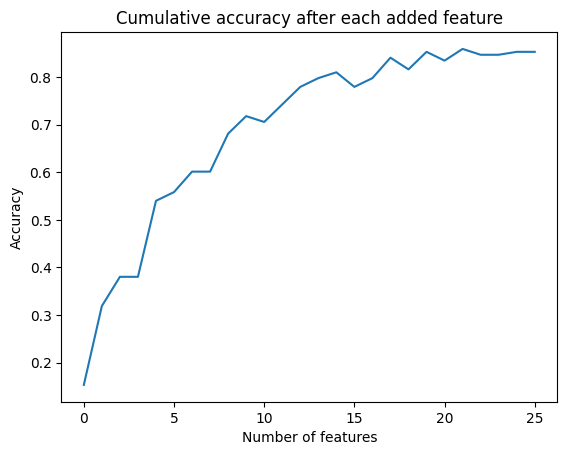

In [95]:
plt.plot(range(len(curr_columns)), accuracies)
plt.title('Cumulative accuracy after each added feature')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

We extract the "important" features which add significant accuracy to the model, giving us a refined list. There were some random fluctuations within 2% accuracy for the less important features, so we define a threshold of 3% added to the accuracy.

In [96]:
hyp_columns = ["count"]
for i in range(1, len(curr_columns)):
    if accuracies[i] - accuracies[i - 1] >= 0.03:
        hyp_columns.append(curr_columns[i])
print(hyp_columns)

['count', 'avg_sale_price', 'sales_ratio_q1', 'FYE_total_net_grand_list', 'Grand_list_personal_property', 'Grand_list_apartment', 'Grand_list_commercial', 'Grand_list_industrial', 'Grand_list_land_use', 'Mill_rate_motor_vehicle', 'Net_current_education_expenditures_CSDE']


Next, we tune the number of estimators for the classifier.

In [19]:
cl_inp_df = raw_data[hyp_columns]
cl_res_df = raw_data[['county']]

cl_inp_train, cl_inp_test, cl_res_train, cl_res_test = train_test_split(cl_inp_df, cl_res_df, test_size=0.2, random_state=42)
scaler = StandardScaler()
cl_inp_train = scaler.fit_transform(cl_inp_train)
cl_inp_test = scaler.transform(cl_inp_test)

n_estimators = [10, 50, 100, 500, 1000]
max_accuracy = 0
best_n_estimator = 10
for n_estimator in n_estimators:
    classifier = RandomForestClassifier(n_estimators=n_estimator, random_state=42)
    classifier.fit(cl_inp_train, cl_res_train)
    cl_res_pred = classifier.predict(cl_inp_test)
    accuracy = accuracy_score(cl_res_test, cl_res_pred)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_n_estimator = n_estimator
print(max_accuracy, best_n_estimator)

0.852760736196319 500


500 estimators is best, so we finalize the model with that parameter.

### Measuring and visualizing model performance

We measure the precision, recall, and accuracy for the tuned model. 

We also plot the confusion matrix. We can see the model is accurate in predicting most counties within 2 wrong predictions. The most often confused prediction was classifying New London as Middlesex, which could indicate that those two counties have more similar characteristics.

In [31]:
classifier = RandomForestClassifier(n_estimators=best_n_estimator, random_state=42)
classifier.fit(cl_inp_train, cl_res_train)
cl_res_pred = classifier.predict(cl_inp_test)
print(f"Accuracy: {accuracy_score(cl_res_test, cl_res_pred)}, Precision: {precision_score(cl_res_test, cl_res_pred, average='weighted')}, Recall: {recall_score(cl_res_test, cl_res_pred, average='weighted')}")

Accuracy: 0.852760736196319, Precision: 0.876896858708479, Recall: 0.852760736196319


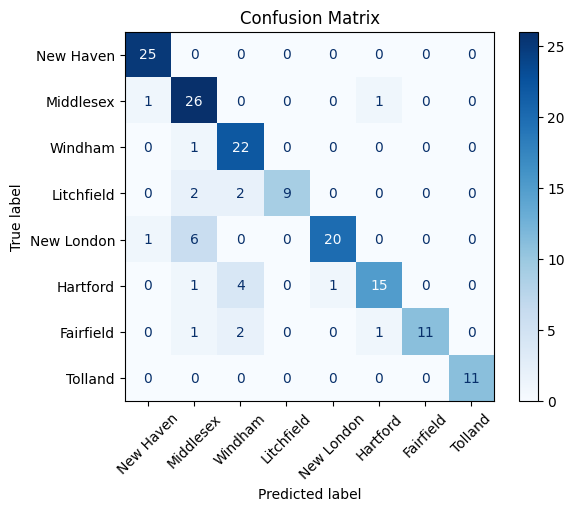

In [29]:
cm = confusion_matrix(cl_res_test, cl_res_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["New Haven","Middlesex","Windham","Litchfield","New London","Hartford","Fairfield","Tolland"])

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

### Final Summary of Model

**Goal**: Classify the county based on given municipal features.

**Features**: 
- Sale count
- Average Sale Price
- Sales Ratio Quartile 1
- FYE Total Net Grand List
- Grand list: personal property
- Grand list: apartment
- Grand list: commercial
- Grand list: industrial
- Grand list: Land use
- Mill rate: motor vehicle
- Net current education expenditures

**Metrics**:
Accuracy: 0.853, Precision: 0.877, Recall: 0.853

**Evaluation**: All values are >=0.85, indicating it does a good job of identifying the county from the chosen features. Since there are 8 counties, a random choice would have an accuracy of only 0.125. By combining the findings of this model and future clustering, we can form "similar" classes of municipalities using important features. We may be able to find stronger relationships and make more accurate predictions for certain classes of municipalities.

## Regression: OLS

For our second model, we examine how closely related income and home prices are. Intuitively it makes sense that they would be related, as towns with wealthier residents should have fancier and more expensive houses. However, are they very closely related, or are there nuances?

We once again split our dataset into training and test sets, and run an OLS model.

In [74]:
reg_inp_df = raw_data[['median_sale_price', 'Per_capita_income_ACS']].dropna()
reg_res_df = reg_inp_df[['median_sale_price']]

reg_inp_train, reg_inp_test, reg_res_train, reg_res_test = train_test_split(reg_inp_df, reg_res_df, test_size=0.2, random_state=42)

# # print(reg_inp_train)

regression = sm.ols(formula="median_sale_price ~ Per_capita_income_ACS", data=reg_inp_train).fit()
reg_res_pred = regression.predict(reg_inp_test)

rmse = np.sqrt(mean_squared_error(reg_res_test, reg_res_pred))
mae = mean_absolute_error(reg_res_test, reg_res_pred)

print(rmse, mae)

print(regression.summary())

128888.47367953949 77828.83801496544
                            OLS Regression Results                            
Dep. Variable:      median_sale_price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     1774.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):          1.87e-172
Time:                        22:14:59   Log-Likelihood:                -6971.5
No. Observations:                 540   AIC:                         1.395e+04
Df Residuals:                     538   BIC:                         1.396e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

### Model Performance Metrics

R-squared is 0.767, which suggests a fairly strong relationship between median sale price and per capita income. Based on the coefficient, for 10000 increase in income, the model predicts an increase of 97474 in home price.

Calculated errors are RMSE: 128888 and MAE: 77828. These are pretty large considering what median sale prices are in most municipalities:

In [70]:
bins = [100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 2000000]  # Define bin edges
labels = ['100k-200k', '200k-300k', '300k-400k', '400k-500k', '500k-600k', '600k-700k', '700k-800k', '800k-900k', '900k-1m', '1m+']  # Optional labels

raw_data['binned'] = pd.cut(raw_data['median_sale_price'], bins=bins, labels=labels, right=True)

counts = raw_data['binned'].value_counts()

print(counts)

binned
200k-300k    356
300k-400k    210
100k-200k     87
400k-500k     68
500k-600k     39
1m+           21
700k-800k     12
600k-700k     11
900k-1m        5
800k-900k      3
Name: count, dtype: int64


Most homes are within the 100k-400k range. Since RMSE is significantly higher than MAE, there are likely outliers that the model is not predicting well.

### Visualizing the model predictions

We plot the predictions vs actual values. We see that homes on the low end fall near the predicted line, but there are a few expensive municipalities which deviate significantly. Sale prices are much more expensive than what is predicted based on income.

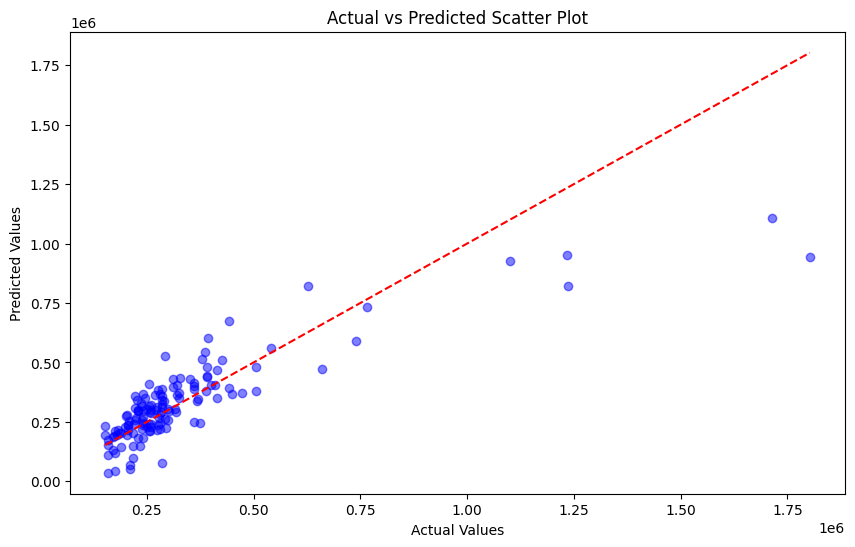

In [87]:
# reg_res_test = reg_res_test['median_sale_price'].to_numpy()
# reg_res_pred = reg_res_pred.to_numpy()

plt.figure(figsize=(10,6))
plt.scatter(reg_res_test, reg_res_pred, alpha=0.5, color='blue')
plt.plot([min(reg_res_test), max(reg_res_test)], [min(reg_res_test), max(reg_res_test)], 'r--')  # Perfect predictions line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Scatter Plot")
plt.show()

### Comparing without outliers

We try removing the most expensive towns, where median sale price is above 1 million, and compare model performance. We see that RMSE and MAE have dropped significantly, to 71304 and 51331 respectively, indicating that the very expensive towns greatly increased the errors.

In [89]:
reg_inp_df = raw_data[['median_sale_price', 'Per_capita_income_ACS']].dropna()
reg_inp_df = reg_inp_df.drop(reg_inp_df[reg_inp_df.median_sale_price > 1000000].index)
reg_res_df = reg_inp_df[['median_sale_price']]

reg_inp_train, reg_inp_test, reg_res_train, reg_res_test = train_test_split(reg_inp_df, reg_res_df, test_size=0.2, random_state=42)

regression = sm.ols(formula="median_sale_price ~ Per_capita_income_ACS", data=reg_inp_train).fit()
reg_res_pred = regression.predict(reg_inp_test)

rmse = np.sqrt(mean_squared_error(reg_res_test, reg_res_pred))
mae = mean_absolute_error(reg_res_test, reg_res_pred)

print(rmse, mae)

71304.63425925904 51331.53733791497


### Final Summary of Model

**Goal**: Predict the median home price based on per capita income.

**Metrics**:
R-squared: 0.767, RMSE: 128888, MAE: 77828

**Evaluation**: The model does a decent job at predicting median home price for most municipalities. However, the most expensive towns, particularly with home prices above 1 million, do not fit well with the linear model. One possible explanation is that wealthy individuals own assets which do not count as income, so they can afford homes which are more expensive relative to income.